# Exercise 13

This particular Automobile Data Set includes a good mix of categorical values as well as continuous values and serves as a useful example that is relatively easy to understand. Since domain understanding is an important aspect when deciding how to encode various categorical values - this data set makes a good case study.

Read the data into Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
# Define the headers since the data does not have any
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
           "num_doors", "body_style", "drive_wheels", "engine_location",
           "wheel_base", "length", "width", "height", "curb_weight",
           "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
           "city_mpg", "highway_mpg", "price"]

# Read in the CSV file and convert "?" to NaN
df = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/autos/imports-85.data",
                  header=None, names=headers, na_values="?" )
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [2]:
df.shape

(205, 26)

In [3]:
df.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
num_doors             object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_cylinders         object
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

In [4]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,engine_type,num_cylinders,fuel_system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


# Exercise 13.1


Does the database contain missing values? If so, replace them using one of the methods explained in class

In [5]:
df.isnull().sum()

symboling             0
normalized_losses    41
make                  0
fuel_type             0
aspiration            0
num_doors             2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

El dataframe tiene valores faltantes en las siguientes columnnas:
* normalized_losses
* num_doors
* bore
* stroke
* hoursepower
* peak_rpm
* price

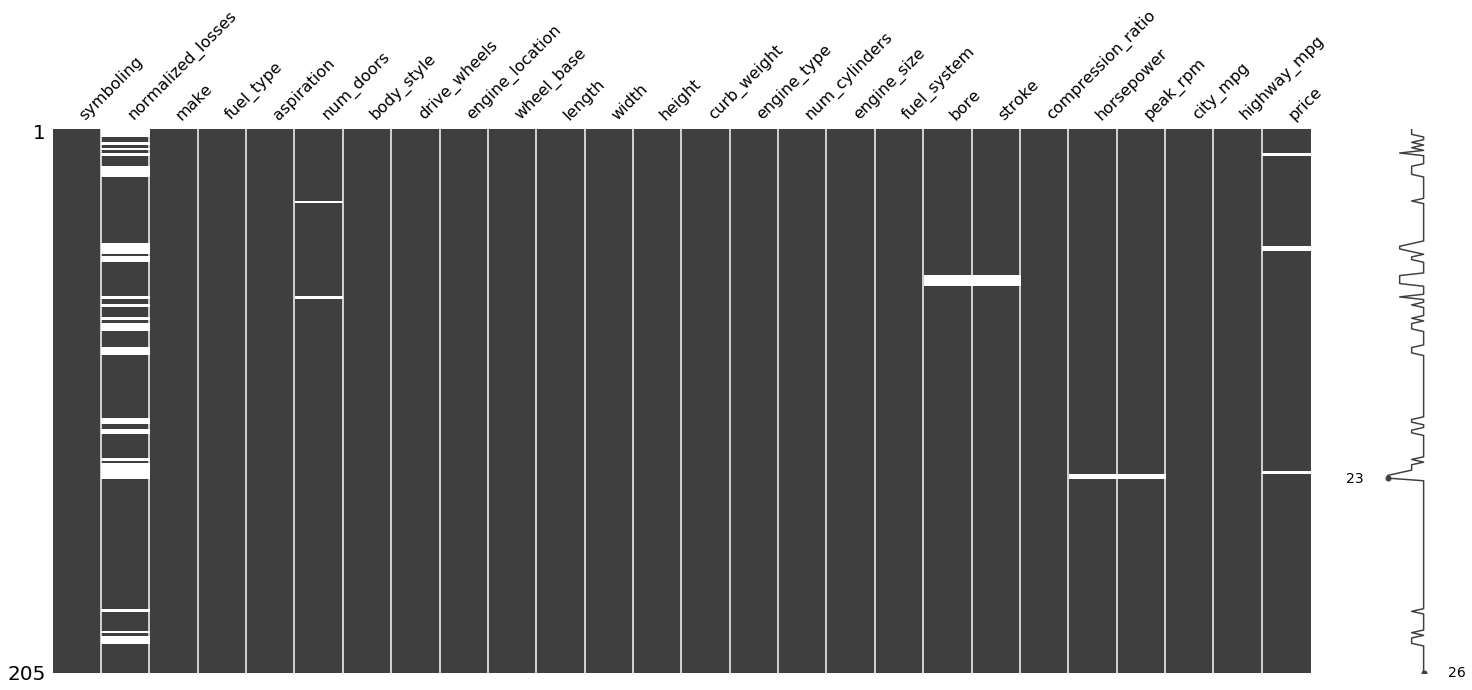

In [6]:
msno.matrix(df)

Como podemos observar, la variable normalized_losses es la que mayor número de missing values tiene en todo el dataframe. A continuación se puede observar la matriz de correlación de valores faltantes donde -1 es que si una variable tiene missing values la otra no los tiene, valores cercanos a 0 es que la presencia de valores faltantes en una columna no tiene ninguna relación con la otra y si aparecen valores tendientes a 1 es que si en una columna tenemos valores faltantes, en la otra muy probablemente también tendrá missing values en esa observación.

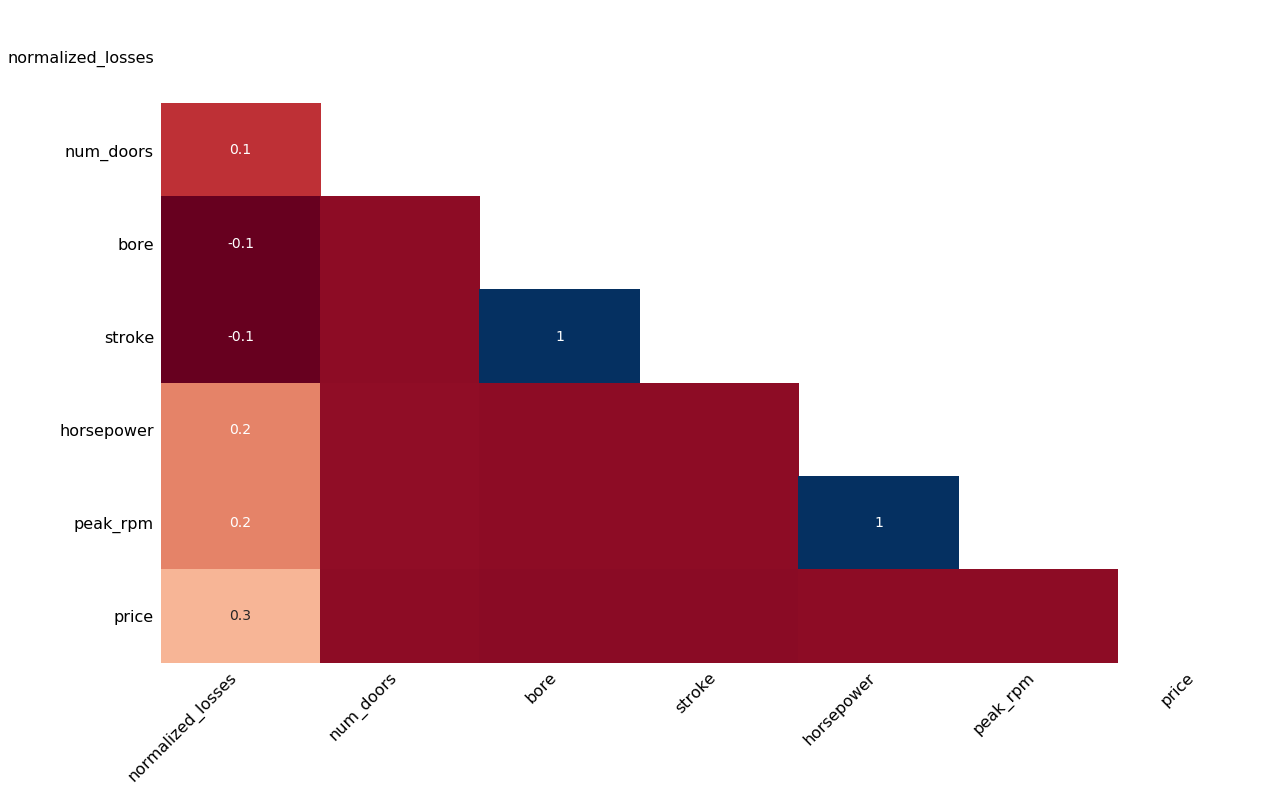

In [7]:
msno.heatmap(df)

Se puede observar la correlación perfecta entre la variable bore y stroke, tambien con peak_rpm y horsepower mientras que la columna normalized_losses tiene más correlación con hoursepower y peak_rpm que con price o num_doors. 

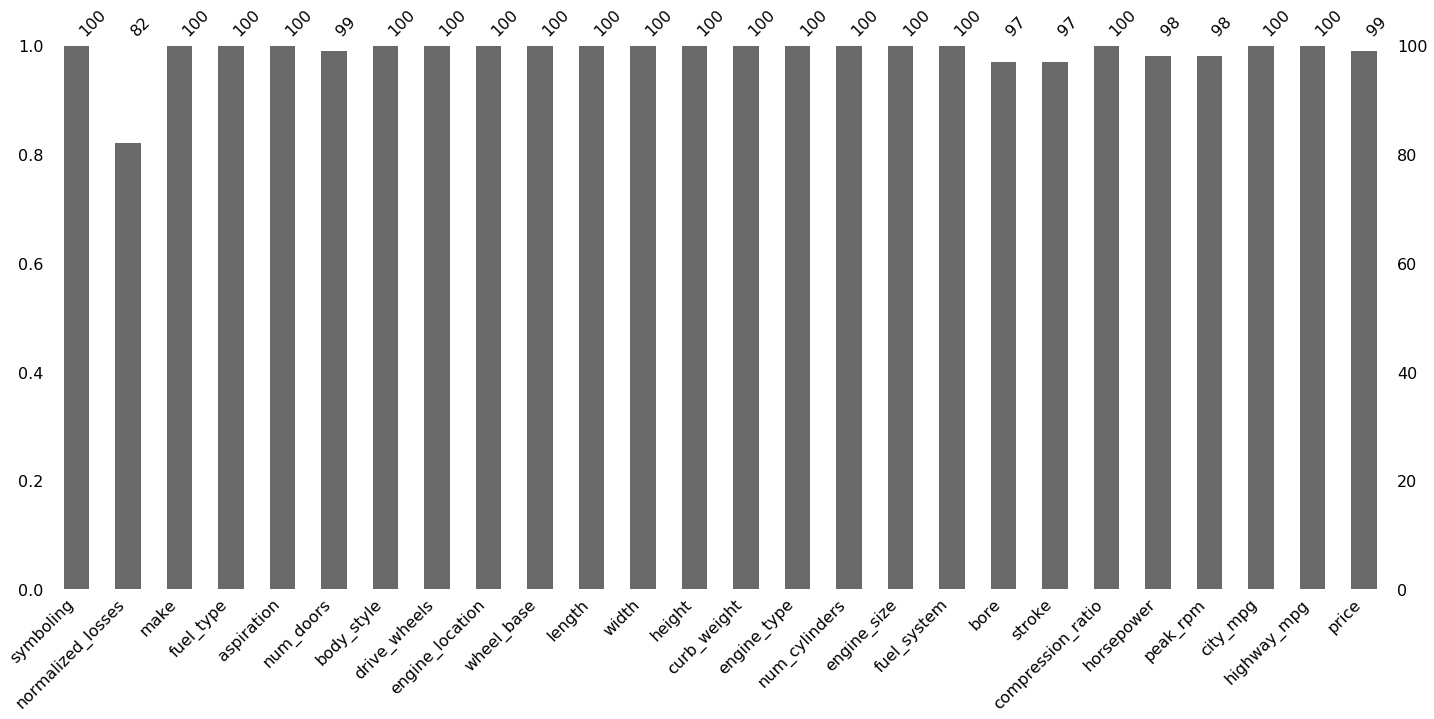

In [8]:
msno.bar(df.sample(100))

Es observable que en una muestra aleatoria de 100 observaciones en mas del 80% de los casos hay valores faltantes solo en la columna de normalized_losses. Se procede a suplir los valores faltantes en las columnas mencionadas

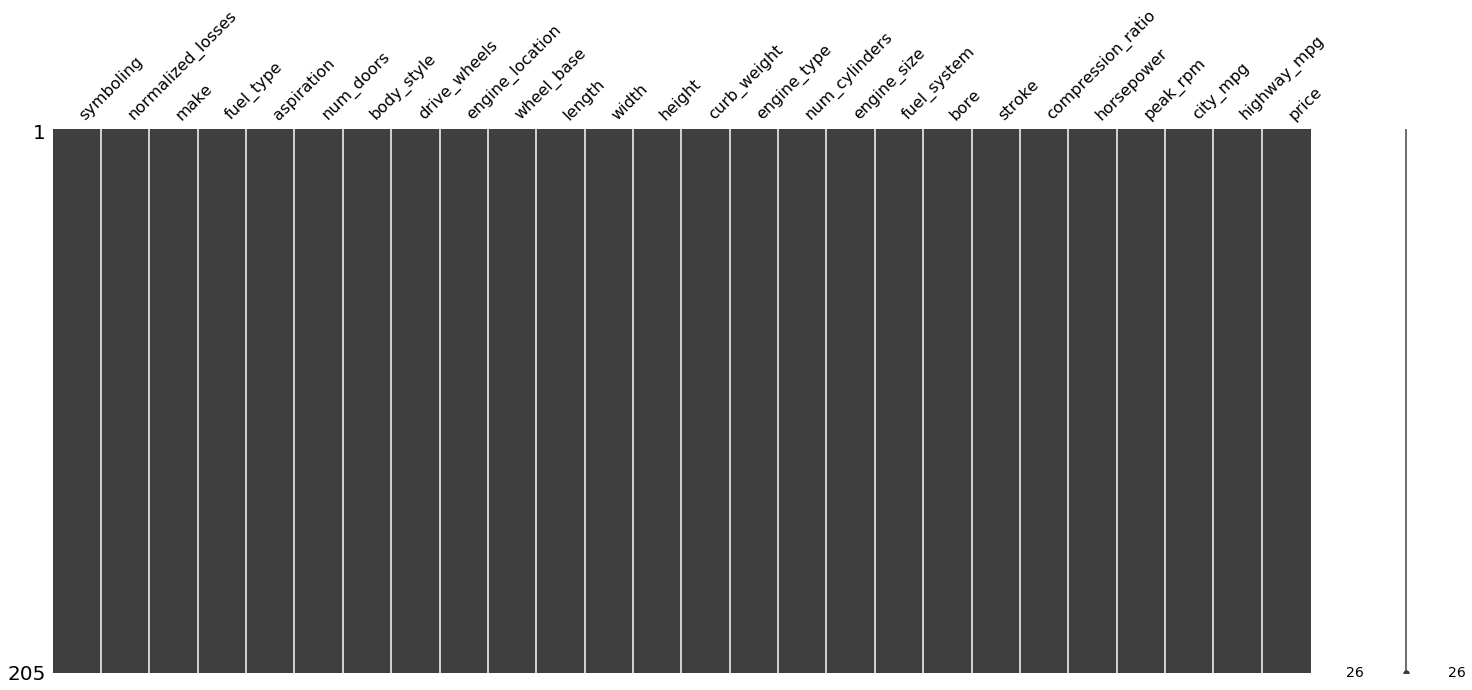

In [9]:
df.price.fillna(df.price.median(), inplace=True)
df.normalized_losses.fillna(method='bfill', inplace=True)
df.num_doors.fillna(method='ffill', inplace=True)
df.bore.fillna(method='ffill', inplace=True)
df.stroke.fillna(method='ffill', inplace=True)
df.horsepower.fillna(method='ffill', inplace=True)
df.peak_rpm.fillna(method='ffill', inplace=True)
msno.matrix(df)

# Exercise 13.2

Split the data into training and testing sets

Train a Random Forest Regressor to predict the price of a car using the nominal features

In [10]:
feature_cols = list(set(df.columns)-set(obj_df.columns))
X=df[feature_cols]
y=X.price
X=X.drop(['price'], axis=1)
X.head(10)

,length,height,wheel_base,normalized_losses,curb_weight,horsepower,width,bore,symboling,engine_size,stroke,peak_rpm,highway_mpg,compression_ratio,city_mpg
0,168.8,48.8,88.6,164.0,2548,111.0,64.1,3.47,3,130,2.68,5000.0,27,9.0,21
1,168.8,48.8,88.6,164.0,2548,111.0,64.1,3.47,3,130,2.68,5000.0,27,9.0,21
2,171.2,52.4,94.5,164.0,2823,154.0,65.5,2.68,1,152,3.47,5000.0,26,9.0,19
3,176.6,54.3,99.8,164.0,2337,102.0,66.2,3.19,2,109,3.40,5500.0,30,10.0,24
4,176.6,54.3,99.4,164.0,2824,115.0,66.4,3.19,2,136,3.40,5500.0,22,8.0,18
5,177.3,53.1,99.8,158.0,2507,110.0,66.3,3.19,2,136,3.40,5500.0,25,8.5,19
6,192.7,55.7,105.8,158.0,2844,110.0,71.4,3.19,1,136,3.40,5500.0,25,8.5,19
7,192.7,55.7,105.8,158.0,2954,110.0,71.4,3.19,1,136,3.40,5500.0,25,8.5,19
8,192.7,55.9,105.8,158.0,3086,140.0,71.4,3.13,1,131,3.40,5500.0,20,8.3,17
9,178.2,52.0,99.5,192.0,3053,160.0,67.9,3.13,0,131,3.40,5500.0,22,7.0,16


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.describe()

,length,height,wheel_base,normalized_losses,curb_weight,horsepower,width,bore,symboling,engine_size,stroke,peak_rpm,highway_mpg,compression_ratio,city_mpg
count,137.00000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,174.90000,53.788321,98.943066,128.313869,2580.919708,108.744526,66.005109,3.320073,0.875912,127.321168,3.252555,5171.167883,30.270073,9.935109,24.751825
std,12.36723,2.516769,6.085793,36.128397,526.496928,45.999525,2.205785,0.272468,1.233391,41.964259,0.312516,475.569420,6.293675,3.665039,5.955449
min,150.00000,47.800000,88.600000,65.000000,1837.000000,52.000000,61.800000,2.540000,-2.000000,70.000000,2.070000,4150.000000,16.000000,7.000000,13.000000
25%,166.80000,52.000000,94.500000,101.000000,2191.000000,73.000000,64.200000,3.150000,0.000000,98.000000,3.110000,4800.000000,25.000000,8.500000,19.000000
50%,173.20000,54.100000,96.900000,122.000000,2425.000000,97.000000,65.500000,3.310000,1.000000,120.000000,3.270000,5200.000000,30.000000,9.000000,24.000000
75%,186.60000,55.700000,101.200000,154.000000,2975.000000,116.000000,66.900000,3.540000,2.000000,141.000000,3.400000,5500.000000,34.000000,9.400000,30.000000
max,202.60000,59.800000,115.600000,256.000000,4066.000000,288.000000,72.300000,3.940000,3.000000,326.000000,4.170000,6600.000000,47.000000,23.000000,38.000000


In [12]:
rf = RandomForestRegressor(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1700.0846 degrees.
Accuracy = 86.56%.
Model Performance
Average Error: 1843.9531 degrees.
Accuracy = 86.26%.
Improvement of -0.35%.


In [14]:
y_pred = best_random.predict(X_test)

# Exercise 13.3

Create dummy variables for the categorical features

Train a Random Forest Regressor and compare

In [15]:
feature_cols = obj_df.columns
X=df[feature_cols]
y=df.price
X.head(10)

,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,engine_type,num_cylinders,fuel_system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi
5,audi,gas,std,two,sedan,fwd,front,ohc,five,mpfi
6,audi,gas,std,four,sedan,fwd,front,ohc,five,mpfi
7,audi,gas,std,four,wagon,fwd,front,ohc,five,mpfi
8,audi,gas,turbo,four,sedan,fwd,front,ohc,five,mpfi
9,audi,gas,turbo,two,hatchback,4wd,front,ohc,five,mpfi


In [16]:
X = pd.get_dummies(X)
X.head(10)

,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,...,num_cylinders_twelve,num_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = RandomForestRegressor(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model Performance
Average Error: 2627.7958 degrees.
Accuracy = 78.51%.
Model Performance
Average Error: 2338.6625 degrees.
Accuracy = 80.82%.
Improvement of 2.95%.


# Exercise 13.4

Apply two other methods of categorical encoding

compare the results

# Polynomial coding

In [20]:
import category_encoders as ce
X_ = ce.PolynomialEncoder().fit_transform(df.drop(['price'], axis=1))
X.head(20)

,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,...,num_cylinders_twelve,num_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.33, random_state=42)
rf = RandomForestRegressor(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model Performance
Average Error: 1667.1836 degrees.
Accuracy = 87.14%.
Model Performance
Average Error: 1770.2722 degrees.
Accuracy = 86.28%.
Improvement of -0.99%.


# Helmert Coding

In [22]:
X_ = ce.HelmertEncoder().fit_transform(df.drop(['price'], axis=1))
X_.head()

,intercept,symboling,normalized_losses,make_0,make_1,make_2,make_3,make_4,make_5,make_6,...,fuel_system_4,fuel_system_5,fuel_system_6,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,1,3,164.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,164.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,1,164.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,2.68,3.47,9.0,154.0,5000.0,19,26
3,1,2,164.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,3.19,3.40,10.0,102.0,5500.0,24,30
4,1,2,164.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,3.19,3.40,8.0,115.0,5500.0,18,22


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.33, random_state=42)
rf = RandomForestRegressor(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model Performance
Average Error: 1764.7110 degrees.
Accuracy = 87.17%.
Model Performance
Average Error: 1881.1864 degrees.
Accuracy = 85.53%.
Improvement of -1.89%.
